# Question 3: Feature Selection on Bank Marketing (duration excluded)

Dataset: `Data/bank-additional-full.csv` (41,188 rows, 20 usable features after dropping `duration`, which leaks outcome). Target: `y` (yes≈11%). Using 80/20 stratified holdout.


AUC (top 7 features): 0.773782371809991
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.905     0.992     0.946      7310
           1      0.730     0.181     0.290       928

    accuracy                          0.900      8238
   macro avg      0.818     0.586     0.618      8238
weighted avg      0.885     0.900     0.872      8238



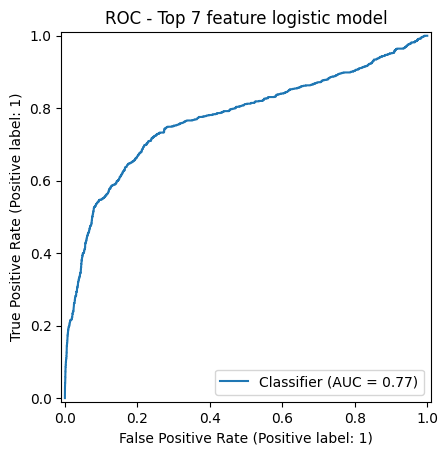

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Data/bank-additional-full.csv', sep=';')
df = df.drop(columns=['duration'])  # Remove duration to avoid leakage
y = (df['y'] == 'yes').astype(int)
df['y_binary'] = y
X = df.drop(columns=['y', 'y_binary'])

# Select top 7 features (leak-free)
feat_top = ['euribor3m','age','campaign','nr.employed','pdays','emp.var.rate','cons.conf.idx']
X_top = df[feat_top]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_top, y, test_size=0.2, stratify=y, random_state=42)

pipe_top = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipe_top.fit(X_train_t, y_train_t)

probs_t = pipe_top.predict_proba(X_test_t)[:,1]
preds_t = pipe_top.predict(X_test_t)
auc_t = roc_auc_score(y_test_t, probs_t)
print('AUC (top 7 features):', auc_t)
print('Classification report (threshold=0.5):')
print(classification_report(y_test_t, preds_t, digits=3))

RocCurveDisplay.from_predictions(y_test_t, probs_t)
plt.title('ROC - Top 7 feature logistic model')
plt.show()


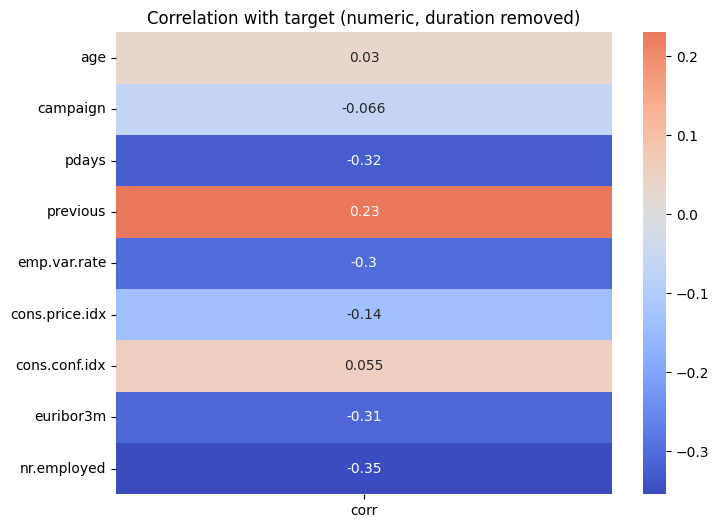

In [2]:

# Correlation heatmap (numeric only)
num_cols = X.select_dtypes(exclude=['object']).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corrwith(y).to_frame('corr'), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with target (numeric, duration removed)')
plt.show()


In [3]:

# Mutual Information on one-hot features
mi_encoder = OneHotEncoder(handle_unknown='ignore')
X_mi = mi_encoder.fit_transform(X)
feature_names = mi_encoder.get_feature_names_out()
mi_scores = mutual_info_classif(X_mi, y, discrete_features=True, random_state=42)
mi_df = pd.DataFrame({'feature': feature_names, 'mi': mi_scores}).sort_values('mi', ascending=False)
mi_df.head(10)


,feature,mi
196,pdays_999,0.030834
207,poutcome_success,0.028978
197,previous_0,0.015001
206,poutcome_nonexistent,0.015001
596,nr.employed_5228.1,0.012550
217,emp.var.rate_1.4,0.012550
112,contact_telephone,0.011646
111,contact_cellular,0.011646
236,cons.price.idx_93.994,0.009957
260,cons.conf.idx_-36.4,0.009957


Explained variance ratio [0.43262262 0.15072846]


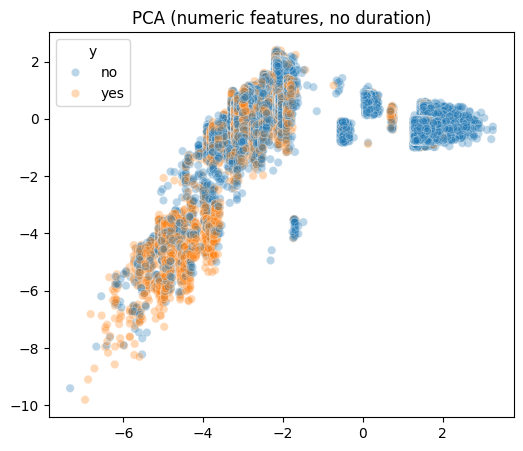

In [4]:

# PCA on numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])
pca = PCA(n_components=2, random_state=42)
pca_vals = pca.fit_transform(X_scaled)
print('Explained variance ratio', pca.explained_variance_ratio_)
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca_vals[:,0], y=pca_vals[:,1], hue=df['y'], alpha=0.3)
plt.title('PCA (numeric features, no duration)')
plt.show()


In [5]:

# Baseline logistic with all remaining features
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

preprocess = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

log_reg = LogisticRegression(max_iter=1000)
pipe_full = Pipeline([
    ('pre', preprocess),
    ('clf', log_reg)
])
pipe_full.fit(X_train, y_train)
probs = pipe_full.predict_proba(X_test)[:,1]
auc_full = roc_auc_score(y_test, probs)
print('AUC all features (no duration)', auc_full)


AUC all features (no duration) 0.800785340700033


In [6]:

# Manual features test
manual_features = ['age','campaign','education','job','previous']
X_man = X[manual_features]
cat_manual = [c for c in manual_features if c in cat_cols]
num_manual = [c for c in manual_features if c in num_cols]
pre_manual = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_manual),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_manual)
])
pipe_manual = Pipeline([
    ('pre', pre_manual),
    ('clf', log_reg)
])
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_man, y, test_size=0.2, stratify=y, random_state=42)
pipe_manual.fit(X_train_m, y_train_m)
probs_m = pipe_manual.predict_proba(X_test_m)[:,1]
auc_manual = roc_auc_score(y_test_m, probs_m)
print('AUC manual', auc_manual)


AUC manual 0.6794155237275343


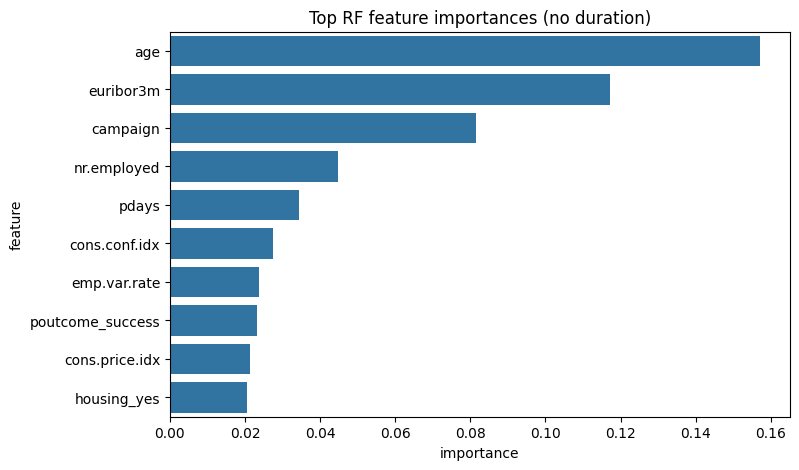

In [7]:

# RandomForest importance (automated selection)
rf = Pipeline([
    ('pre', preprocess),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])
rf.fit(X_train, y_train)
ct = rf.named_steps['pre']
num_features_out = num_cols
cat_features_out = ct.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = list(num_features_out) + list(cat_features_out)
importances = rf.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature': all_features, 'importance': importances}).sort_values('importance', ascending=False)
imp_df.head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df.head(10), x='importance', y='feature')
plt.title('Top RF feature importances (no duration)')
plt.show()


In [8]:

# RFE with logistic regression on one-hot data
log_rfe = LogisticRegression(max_iter=1000)
rfe = RFE(log_rfe, n_features_to_select=5, step=0.1)
rfe.fit(X_mi, y)
selected = [feature_names[i] for i, sel in enumerate(rfe.support_) if sel]
selected


['euribor3m_0.697',
 'euribor3m_0.87',
 'euribor3m_4.021',
 'euribor3m_4.153',
 'euribor3m_4.191']

## Findings (duration removed)

- Strongest numeric signals now: `nr.employed` (-0.35), `pdays` (-0.32), `euribor3m` (-0.31), `emp.var.rate` (-0.30), `previous` (+0.23); `duration` excluded.
- Mutual information: `pdays_999`, `poutcome_success`, `previous_0`, macro-econ buckets (`emp.var.rate`, `nr.employed`, `cons.price.idx`).
- PCA (numeric) variance: PC1≈43% (macro-econ block), PC2≈15% (pdays influence).
- AUC all remaining features ≈0.80 (drop vs earlier 0.94 when duration leaked outcome). Manual features [`age`,`campaign`,`education`,`job`,`previous`] ≈0.68.
- RF top 5 (no duration): `age`, `euribor3m`, `campaign`, `nr.employed`, `pdays` (followed by `cons.conf.idx`, `emp.var.rate`).
- RFE picked `euribor3m` buckets, reinforcing macro rate importance.

**Recommended 5-feature combo (no leakage):** `euribor3m`, `age`, `campaign`, `nr.employed`, `pdays`, `emp.var.rate`, `cons.conf.idx` — balances macro context with campaign history without using `duration`.


## Logistic regression with top 7 features (leak-free)
Using the strongest non-leak features identified after removing `duration`: `euribor3m`, `age`, `campaign`, `nr.employed`, `pdays`, `emp.var.rate`, `cons.conf.idx`. Fit a logistic regression and evaluate holdout performance.


AUC (top 7 features): 0.773782371809991
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.905     0.992     0.946      7310
           1      0.730     0.181     0.290       928

    accuracy                          0.900      8238
   macro avg      0.818     0.586     0.618      8238
weighted avg      0.885     0.900     0.872      8238



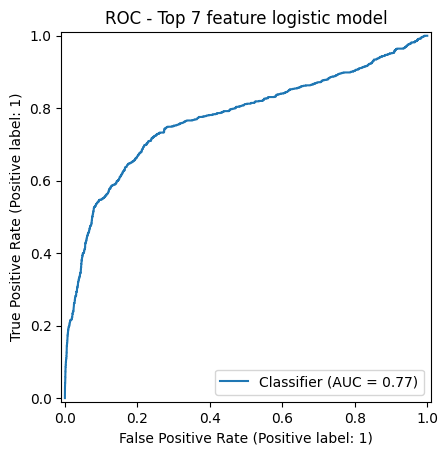

In [9]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# Select top 7 features
feat_top5 = ['euribor3m','age','campaign','nr.employed','pdays', 'emp.var.rate','cons.conf.idx']
X_top = df[feat_top5]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_top, y, test_size=0.2, stratify=y, random_state=42)

pipe_top = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipe_top.fit(X_train_t, y_train_t)

probs_t = pipe_top.predict_proba(X_test_t)[:,1]
preds_t = pipe_top.predict(X_test_t)
auc_t = roc_auc_score(y_test_t, probs_t)
print('AUC (top 7 features):', auc_t)
print('Classification report (threshold=0.5):')
print(classification_report(y_test_t, preds_t, digits=3))

RocCurveDisplay.from_predictions(y_test_t, probs_t)
plt.title('ROC - Top 7 feature logistic model')
plt.show()


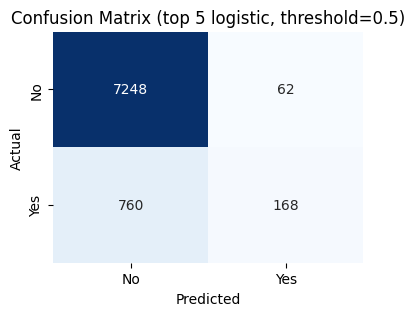

In [10]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_t, preds_t)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (top 5 logistic, threshold=0.5)')
plt.show()


## Threshold sweeps (0.2 and 0.3) for top-7 logistic model
Lowering the decision threshold trades precision for recall on the positive class; we evaluate 0.2 and 0.3.


Threshold 0.5: precision=[0.90509491 0.73043478], recall=[0.99151847 0.18103448], f1=[0.94633764 0.29015544]
              precision    recall  f1-score   support

           0      0.905     0.992     0.946      7310
           1      0.730     0.181     0.290       928

    accuracy                          0.900      8238
   macro avg      0.818     0.586     0.618      8238
weighted avg      0.885     0.900     0.872      8238



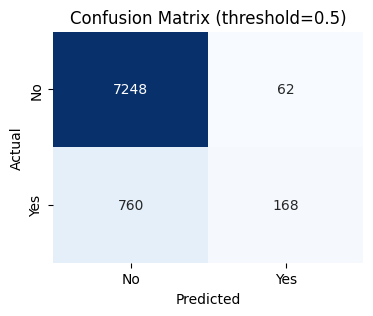

In [11]:

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for thr in [0.5]:
    preds_thr = (probs_t >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test_t, preds_thr, average=None, labels=[0,1])
    print(f"Threshold {thr}: precision={p}, recall={r}, f1={f1}")
    cm = confusion_matrix(y_test_t, preds_thr)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    print(classification_report(y_test_t, preds_thr, digits=3)  )
    plt.title(f'Confusion Matrix (threshold={thr})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


## KNN classifier (top 7 features) for comparison
Using the same leak-free top 7 features (`euribor3m`, `age`, `campaign`, `nr.employed`, `pdays`, `emp.var.rate`, `cons.conf.idx`) with standardization.


KNN AUC (top 5): 0.7181501780744375
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.918     0.945     0.931      7310
           1      0.434     0.332     0.376       928

    accuracy                          0.876      8238
   macro avg      0.676     0.638     0.654      8238
weighted avg      0.863     0.876     0.869      8238



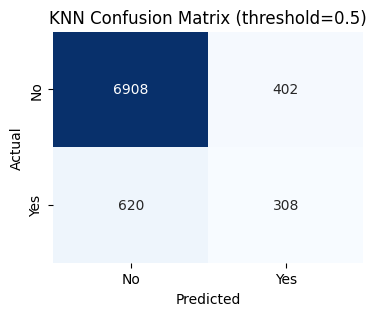

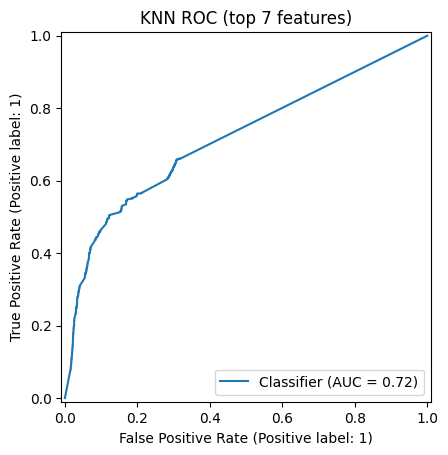

In [12]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', knn)
])
knn_pipe.fit(X_train_t, y_train_t)
knn_probs = knn_pipe.predict_proba(X_test_t)[:,1]
knn_preds = (knn_probs >= 0.5).astype(int)

auc_knn = roc_auc_score(y_test_t, knn_probs)
print('KNN AUC (top 5):', auc_knn)
print('Classification report (threshold=0.5):')
print(classification_report(y_test_t, knn_preds, digits=3))

cm_knn = confusion_matrix(y_test_t, knn_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.title('KNN Confusion Matrix (threshold=0.5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RocCurveDisplay.from_predictions(y_test_t, knn_probs)
plt.title('KNN ROC (top 7 features)')
plt.show()


## Decision Tree classifier (top 7 features) for comparison
Tree model on the same leak-free top 5 numeric features (`euribor3m`, `age`, `campaign`, `nr.employed`, `pdays`, `emp.var.rate`, `cons.conf.idx`).


Decision Tree AUC (top 5): 0.7987246597716874
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.910     0.985     0.946      7310
           1      0.670     0.234     0.347       928

    accuracy                          0.901      8238
   macro avg      0.790     0.610     0.646      8238
weighted avg      0.883     0.901     0.879      8238



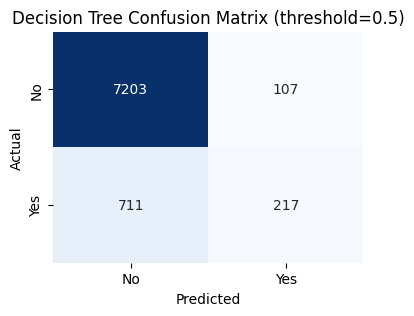

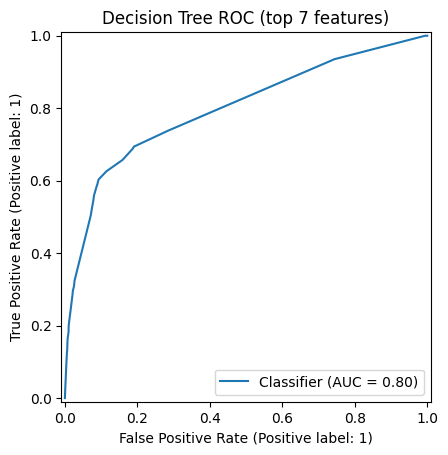

In [13]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix

# Tree does not need scaling
clf_tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, random_state=42)
clf_tree.fit(X_train_t, y_train_t)

tree_probs = clf_tree.predict_proba(X_test_t)[:,1]
tree_preds = (tree_probs >= 0.5).astype(int)

auc_tree = roc_auc_score(y_test_t, tree_probs)
print('Decision Tree AUC (top 5):', auc_tree)
print('Classification report (threshold=0.5):')
print(classification_report(y_test_t, tree_preds, digits=3))

cm_tree = confusion_matrix(y_test_t, tree_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.title('Decision Tree Confusion Matrix (threshold=0.5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RocCurveDisplay.from_predictions(y_test_t, tree_probs)
plt.title('Decision Tree ROC (top 7 features)')
plt.show()


## Naive Bayes (Gaussian) on top 7 features
Baseline probabilistic model using the same leak-free top 5 numeric features (`euribor3m`, `age`, `campaign`, `nr.employed`, `pdays`, `emp.var.rate`, `cons.conf.idx`).


Naive Bayes AUC (top 5): 0.7791010189159866
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.935     0.925     0.930      7310
           1      0.457     0.496     0.476       928

    accuracy                          0.877      8238
   macro avg      0.696     0.710     0.703      8238
weighted avg      0.881     0.877     0.879      8238



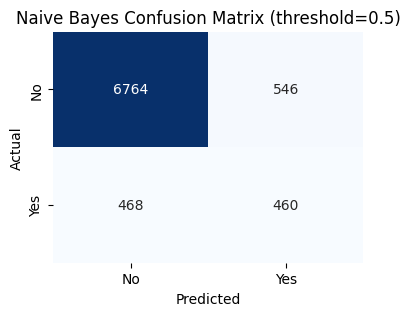

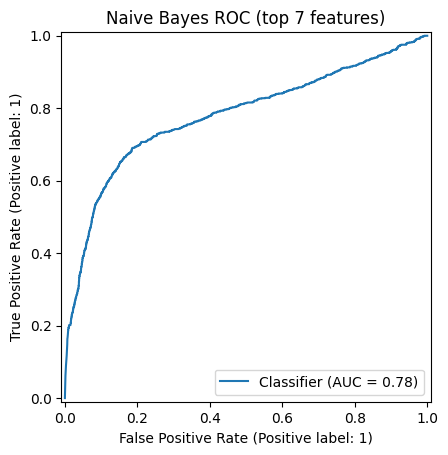

In [14]:

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix

nb_clf = GaussianNB()
nb_clf.fit(X_train_t, y_train_t)

nb_probs = nb_clf.predict_proba(X_test_t)[:,1]
nb_preds = (nb_probs >= 0.5).astype(int)

auc_nb = roc_auc_score(y_test_t, nb_probs)
print('Naive Bayes AUC (top 5):', auc_nb)
print('Classification report (threshold=0.5):')
print(classification_report(y_test_t, nb_preds, digits=3))

cm_nb = confusion_matrix(y_test_t, nb_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.title('Naive Bayes Confusion Matrix (threshold=0.5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RocCurveDisplay.from_predictions(y_test_t, nb_probs)
plt.title('Naive Bayes ROC (top 7 features)')
plt.show()


## Gradient Boosting feature importance (full feature set, no duration)
Tree-ensemble to rank predictive attributes using all leak-free features with one-hot encoding for categoricals.


Gradient Boosting AUC (all features, no duration): 0.8091473212179819
Top 10 features by importance:
             feature  importance
8        nr.employed    0.598806
2              pdays    0.087661
7          euribor3m    0.068507
6      cons.conf.idx    0.053505
61  poutcome_success    0.038529
52         month_oct    0.022760
0                age    0.019684
5     cons.price.idx    0.013582
59  poutcome_failure    0.013182
55   day_of_week_mon    0.011501


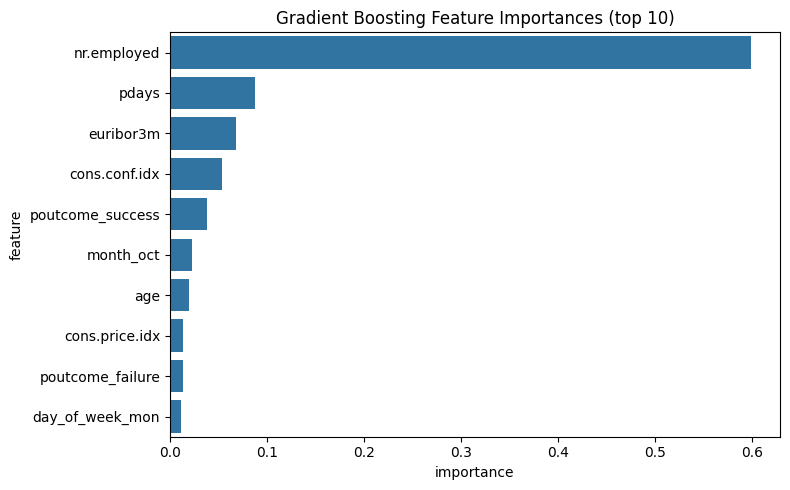

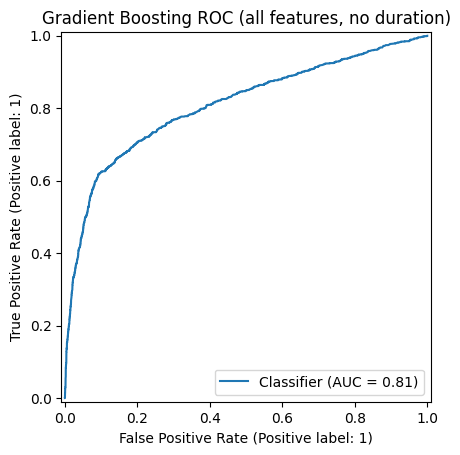

In [15]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

X_full = df.drop(columns=['y','y_binary'])
cat_cols_g = X_full.select_dtypes(include=['object']).columns.tolist()
num_cols_g = X_full.select_dtypes(exclude=['object']).columns.tolist()

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_full, y, test_size=0.2, stratify=y, random_state=42)

pre_gb = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_cols_g),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_g)
])

gb = GradientBoostingClassifier(random_state=42)
pipe_gb = Pipeline([
    ('pre', pre_gb),
    ('clf', gb)
])

pipe_gb.fit(X_train_g, y_train_g)
gb_probs = pipe_gb.predict_proba(X_test_g)[:,1]
auc_gb = roc_auc_score(y_test_g, gb_probs)
print('Gradient Boosting AUC (all features, no duration):', auc_gb)

# Feature importances
ct = pipe_gb.named_steps['pre']
cat_features_out = ct.named_transformers_['cat'].get_feature_names_out(cat_cols_g)
all_features = num_cols_g + list(cat_features_out)
importances = pipe_gb.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature': all_features, 'importance': importances}).sort_values('importance', ascending=False)
print('Top 10 features by importance:')
print(imp_df.head(10))

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df.head(10), x='importance', y='feature')
plt.title('Gradient Boosting Feature Importances (top 10)')
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test_g, gb_probs)
plt.title('Gradient Boosting ROC (all features, no duration)')
plt.show()


## Logistic regression using top Gradient Boosting features (top 10)
Select the original columns corresponding to the most important Gradient Boosting features (duration excluded) and fit a logistic regression using the top 10 unique columns.


Selected columns from GB importances: ['nr.employed', 'pdays', 'euribor3m', 'cons.conf.idx', 'poutcome', 'month', 'age', 'cons.price.idx', 'day_of_week', 'contact']
AUC (logistic on GB-selected cols): 0.7994330510873154
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.909     0.988     0.947      7310
           1      0.701     0.222     0.337       928

    accuracy                          0.902      8238
   macro avg      0.805     0.605     0.642      8238
weighted avg      0.886     0.902     0.878      8238

AUC (logistic on GB-selected cols): 0.7994330510873154
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.909     0.988     0.947      7310
           1      0.701     0.222     0.337       928

    accuracy                          0.902      8238
   macro avg      0.805     0.605     0.642      8238
weighted avg      0.886     0.902     0.878     

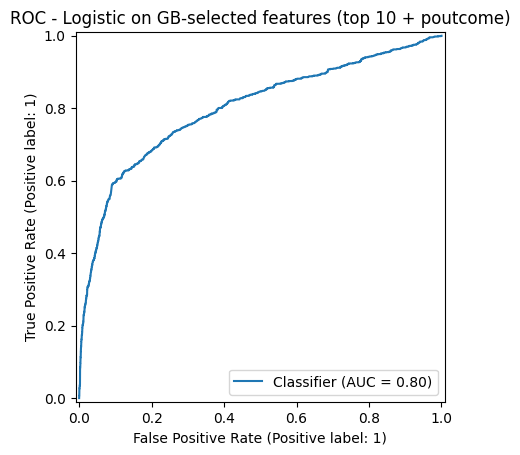

In [16]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt

# Map top GB feature names back to original columns
imp_top = imp_df.head(60)['feature']  # grab enough candidates
base_cols = []
for feat in imp_top:
    if feat in df.columns:
        base = feat
    else:
        base = None
        for col in df.select_dtypes(include=['object']).columns:
            prefix = f"{col}_"
            if feat.startswith(prefix):
                base = col
                break
    if base and base not in base_cols:
        base_cols.append(base)

# Always include poutcome
if 'poutcome' not in base_cols:
    base_cols.append('poutcome')

# keep top 10
base_cols = base_cols[:10]
print('Selected columns from GB importances:', base_cols)

X_sel = df[base_cols]
cat_sel = X_sel.select_dtypes(include=['object']).columns.tolist()
num_sel = X_sel.select_dtypes(exclude=['object']).columns.tolist()

pre_sel = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_sel),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_sel)
])

log_sel = Pipeline([
    ('pre', pre_sel),
    ('clf', LogisticRegression(max_iter=1000))
])

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)
log_sel.fit(X_train_s, y_train_s)
probs_s = log_sel.predict_proba(X_test_s)[:,1]
preds_s = log_sel.predict(X_test_s)
auc_s = roc_auc_score(y_test_s, probs_s)
print('AUC (logistic on GB-selected cols):', auc_s)
print('Classification report (threshold=0.5):')
print(classification_report(y_test_s, preds_s, digits=3))

RocCurveDisplay.from_predictions(y_test_s, probs_s)
plt.title('ROC - Logistic on GB-selected features (top 10 + poutcome)')
plt.show()
